# This notebook seeks to Answer
* How do classifier (e.g.: linear probe) transfer between different types of attacks?

In [1]:
# Import the init_paths module
from init_paths import (
    PROJECT_ROOT,
    DATASETS_DIR,
    ANALYSIS_DIR,
    EXPERIMENTS_DIR,
    IMAGES_DIR,
    GEN_DATA_DIR,
    LOGS_DIR,
    get_project_path
)

Paths initialized successfully. You can now use PROJECT_ROOT, DATASETS_DIR, etc.


In [2]:
import pandas as pd
import sys
import os
import numpy as np
from pathlib import Path
import os
import pandas as pd 
import re

In [5]:
from analysis.unsupervised import *
from analysis.supervised import *
from analysis.models import *

In [6]:
publication = ["public_1", "public_2"][1]
folder_path = DATASETS_DIR / f"prompt_activations/{publication}"
files = os.listdir(folder_path)

models_list = list(models.keys())
model = models_list[0]

for file in files:
    if file.endswith(".pkl") and "rated" in file and model in file: 
      print(file)
      path = folder_path / file

      df = pd.read_pickle(path)

gemma-7b-it_rated.pkl


In [7]:
model_name, num_layers, rating_column, hf_ident, input_size = get_model_details(path)

layer= num_layers - 4

activation_column="prompt_res_activations"
num_samples = len(df)
dataset_name = "wildJailBreak" if "wildJailBreak" in str(path) else "wei_dataset"

In [8]:
if "gemma" in model_name: 
  df = df[~df["jailbreak_prompt_name"].isin(["auto_payload_splitting", "auto_obfuscation", "dev_mode_with_rant", "none"])]
else: 
  df = df[~df["jailbreak_prompt_name"].isin(["auto_payload_splitting", "auto_obfuscation", "dev_mode_with_rant", "none", "gcg", "autodan"])]

In [9]:
asr_values = []

# Calculate ASR (Accuracy Success Rate) for each jailbreak prompt
for jailbreak_prompt in df['jailbreak_prompt_name'].unique():
        # Calculate normalized value counts for each prompt
        ASR = df[df['jailbreak_prompt_name'] == jailbreak_prompt][rating_column].value_counts(normalize=True)
        if "Yes" in ASR:  # Only consider prompts with "Yes" success rates
            asr_values.append((jailbreak_prompt, ASR["Yes"]))

# Sort the ASR values in descending order and select the top 10
top_10_jailbreaks = sorted(asr_values, key=lambda x: x[1], reverse=True)[:10]
    
# Extract the top 10 jailbreak prompt names
top_10_jailbreak_prompt_names = [item[0] for item in top_10_jailbreaks]

# Filter the dataframe to keep only rows matching the top 10 jailbreak prompts or the 'original_prompt'
df = df[(df['jailbreak_prompt_name'].isin(top_10_jailbreak_prompt_names)) | 
            (df['jailbreak_prompt_name'] == 'original_prompt')]


# Display the count of remaining jailbreak_prompt_name values
print(df["jailbreak_prompt_name"].value_counts())


jailbreak_prompt_name
original_prompt           600
leetspeak                 300
gcg                       300
prefix_injection_hello    300
distractors               300
style_injection_json      300
style_injection_short     300
refusal_suppression       300
evil_confidant            300
prefix_injection          300
wikipedia_with_title      300
Name: count, dtype: int64


## Linear Probe

In [10]:
if "gemma" in model_name: 
    def extract_layer(row, layer, activation_column="prompt_res_activations"):
        activation = row[activation_column][layer][0]
        # Average across the first dimension (4 heads) instead of flattening
        return activation.mean(dim=0).cpu().numpy()  # This will give a (3072,) array

else:
    def extract_layer(row, layer):
        return row['prompt_res_activations'][layer][0].cpu().numpy().flatten()


In [11]:
# Add column that has 0 if "rating" is "No" and 1 if "rating" is "Yes"
df['rating_binary'] = df[rating_column].apply(lambda x: 0 if x == "No" else 1)

# Create new columns for each layer
df[f'layer_{layer}'] = df.apply(lambda row: extract_layer(row, layer), axis=1)


## Transfer with Holdout

In [ ]:
# Calculate the layers of interest
layers = range(0, num_layers)

holdout_df = transfer_with_holdout_with_errors(df = df, probe_type = "logistic_regression", layers = layers)


In [ ]:
holdout_df

,test accuracy w/o holdout var,test accuracy SE w/o holdout var,test size w/o holdout var,test accuracy w holdout var,test accuracy SE w holdout var,test size w holdout var
original_prompt,0.680723,0.036184,166,0.59,0.020079,600
leetspeak,0.658683,0.036691,167,0.3,0.026458,300
gcg,0.729412,0.034073,170,0.556667,0.028682,300
prefix_injection_hello,0.629412,0.037042,170,0.183333,0.02234,300
distractors,0.688235,0.035527,170,0.093333,0.016795,300
style_injection_json,0.68323,0.036664,161,0.41,0.028396,300
style_injection_short,0.674556,0.036042,169,0.886667,0.018302,300
refusal_suppression,0.64497,0.036809,169,0.793333,0.023378,300
evil_confidant,0.680982,0.036507,163,0.85,0.020616,300
prefix_injection,0.698795,0.035608,166,0.123333,0.018984,300


In [14]:
save_dir = DATASETS_DIR / f"{publication}/{model_name}"
os.makedirs(save_dir, exist_ok=True)

holdout_df.to_csv(f"{save_dir}/transfer_holdout_linear.csv")


In [ ]:
print('test accuracy w holdout var' in holdout_df.columns)
print('test accuracy w/o holdout var' in holdout_df.columns)


True
True


In [16]:
mean_transfer = round(holdout_df["test accuracy w holdout var"].mean(),2)

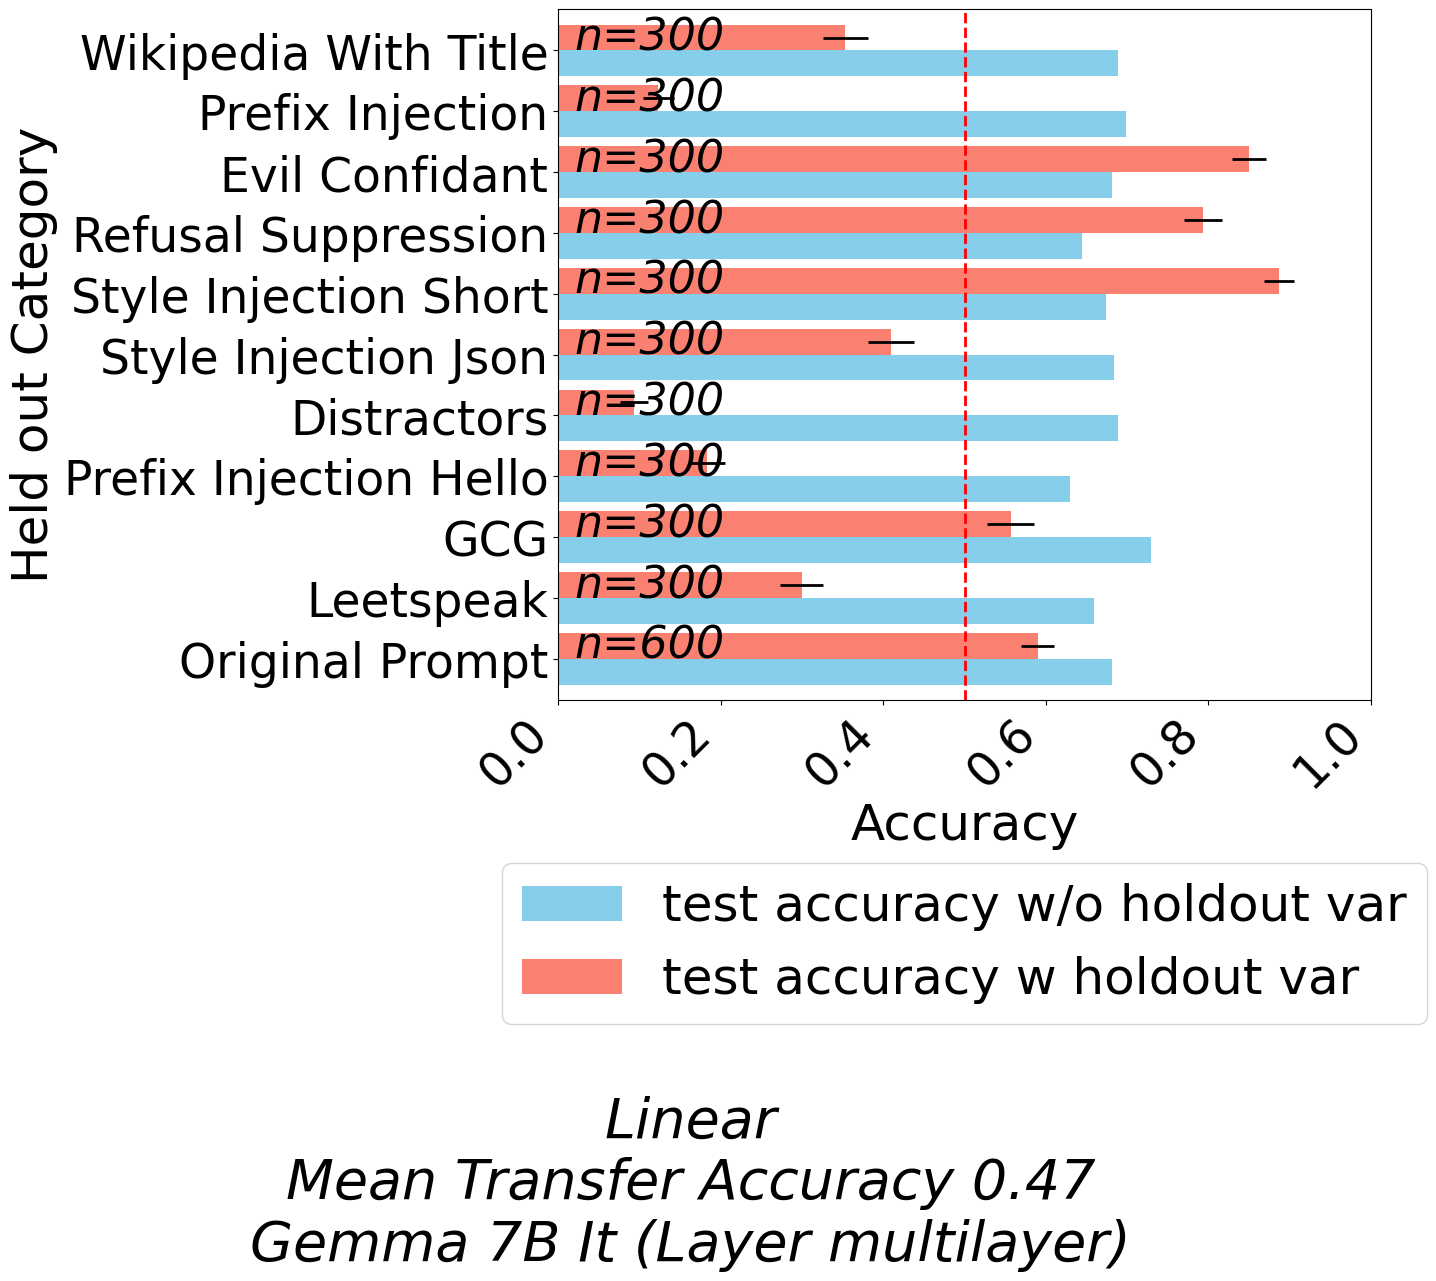

In [17]:
if len(layers) > 1: layer = "multilayer"

holdout_transfer_graph(holdout_df= holdout_df, dataset_name=dataset_name, model_name = model_name, layer = layer, probe_type = "Linear", mean_tranfer_score=mean_transfer)

## MLP Probe

In [18]:
from analysis.supervised import *

## Transfer with Holdout

In [ ]:
holdout_df = transfer_with_holdout_with_errors(df = df, probe_type = "MLP", layers = layers, input_size = input_size)


In [20]:
holdout_df

,test accuracy w/o holdout var,test accuracy SE w/o holdout var,test size w/o holdout var,test accuracy w holdout var,test accuracy SE w holdout var,test size w holdout var
original_prompt,0.656627,0.036854,166,0.65,0.019472,600
leetspeak,0.688623,0.035832,167,0.346667,0.027477,300
gcg,0.676471,0.03588,170,0.263333,0.025429,300
prefix_injection_hello,0.623529,0.037159,170,0.623333,0.027976,300
distractors,0.664706,0.036208,170,0.093333,0.016795,300
style_injection_json,0.732919,0.034869,161,0.356667,0.027656,300
style_injection_short,0.692308,0.035503,169,0.886667,0.018302,300
refusal_suppression,0.64497,0.036809,169,0.753333,0.024888,300
evil_confidant,0.693252,0.03612,163,0.83,0.021687,300
prefix_injection,0.710843,0.035188,166,0.543333,0.028759,300


In [21]:
# Create parent directories if they don't exist
save_dir = DATASETS_DIR / f"{publication}/{model_name}"
os.makedirs(save_dir, exist_ok=True)

holdout_df.to_csv(f"{save_dir}/transfer_holdout_mlp.csv")


In [22]:
# get mean of holdout_df["Test Set (Holdout)"]
mean_transfer = round(holdout_df["test accuracy w holdout var"].mean(),2)

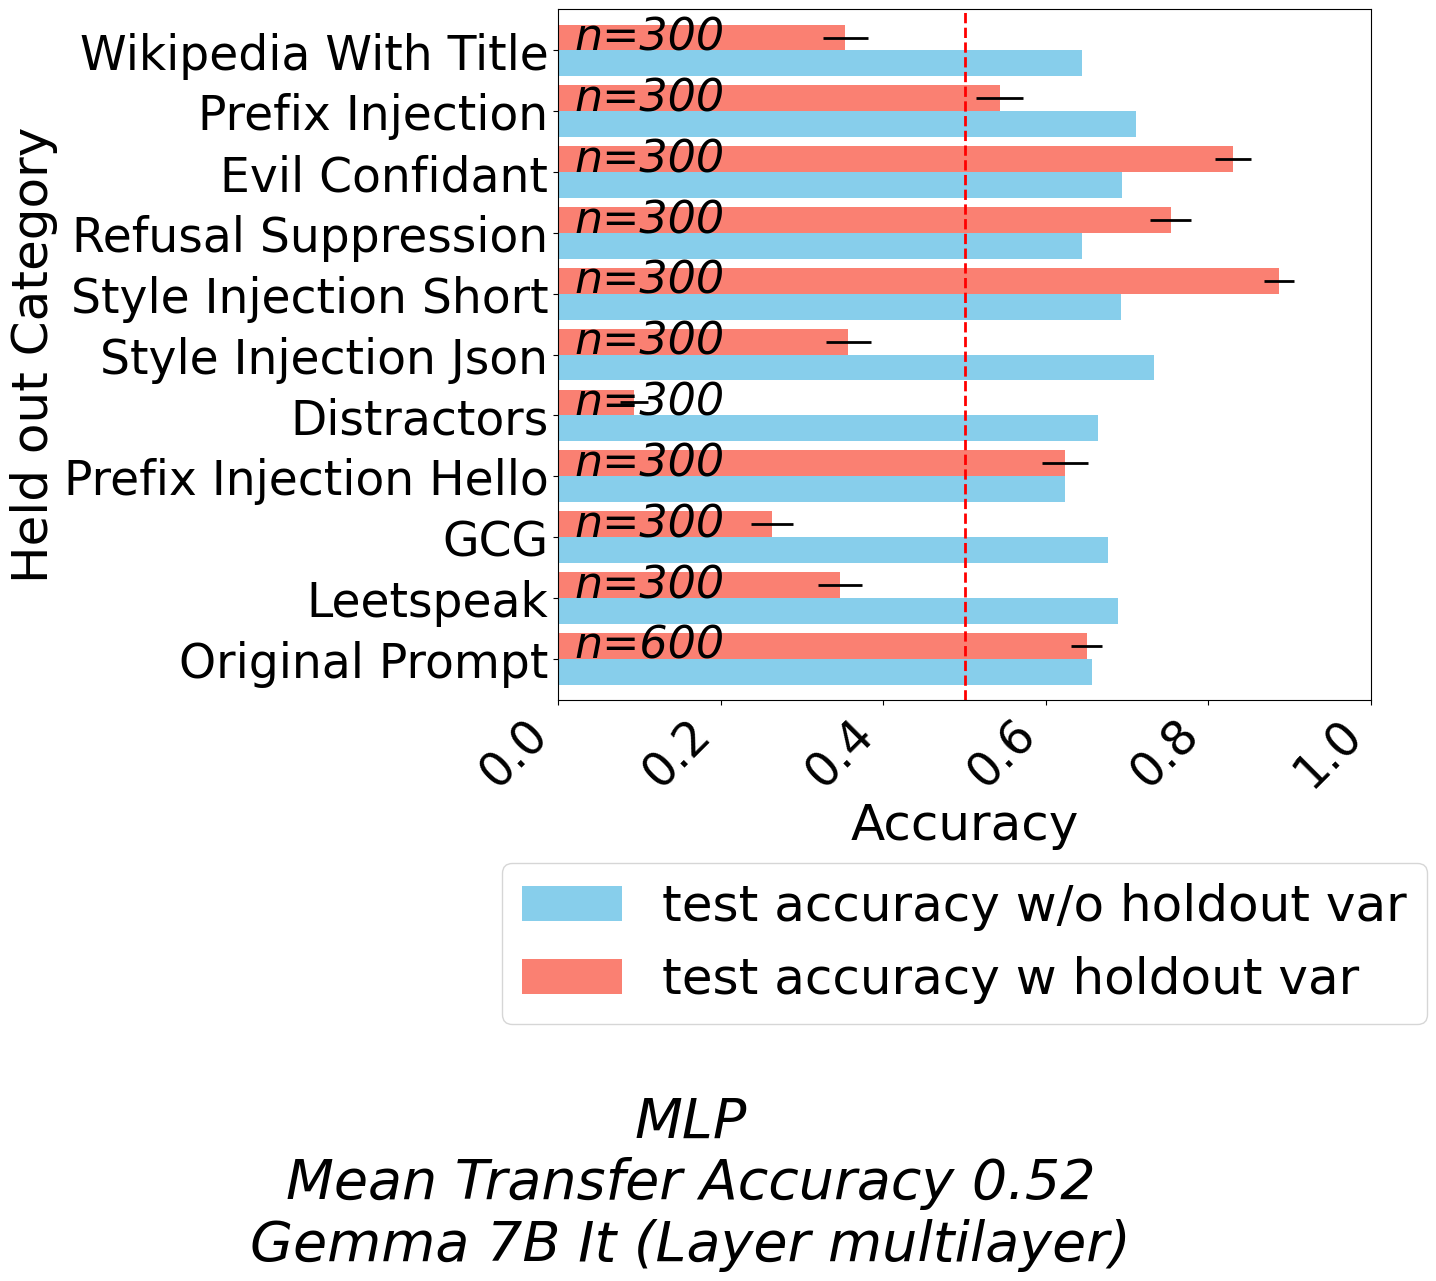

In [23]:
if len(layers) > 1: layer = "multilayer"

plot = holdout_transfer_graph(holdout_df= holdout_df, dataset_name=dataset_name, model_name = model_name, layer = layer, probe_type = "MLP", mean_tranfer_score= mean_transfer)

# Transformer probe

In [ ]:
holdout_df = transfer_with_holdout_with_errors(df = df, probe_type = "transformer", layers = layers, input_size = input_size)


In [25]:
holdout_df


,test accuracy w/o holdout var,test accuracy SE w/o holdout var,test size w/o holdout var,test accuracy w holdout var,test accuracy SE w holdout var,test size w holdout var
original_prompt,0.620482,0.037664,166,0.896667,0.012427,600
leetspeak,0.700599,0.035441,167,0.64,0.027713,300
gcg,0.664706,0.036208,170,0.65,0.027538,300
prefix_injection_hello,0.652941,0.03651,170,0.83,0.021687,300
distractors,0.647059,0.036652,170,0.093333,0.016795,300
style_injection_json,0.658385,0.037376,161,0.643333,0.027656,300
style_injection_short,0.615385,0.037423,169,0.86,0.020033,300
refusal_suppression,0.621302,0.037313,169,0.1,0.017321,300
evil_confidant,0.687117,0.036317,163,0.836667,0.021343,300
prefix_injection,0.716867,0.034967,166,0.783333,0.023785,300


In [26]:
save_dir = DATASETS_DIR / f"{publication}/{model_name}"
os.makedirs(save_dir, exist_ok=True)

holdout_df.to_csv(f"{save_dir}/transfer_holdout_transformer.csv")

In [27]:
# get mean of holdout_df["Test Set (Holdout)"]
mean_transfer = round(holdout_df["test accuracy w holdout var"].mean(),2)

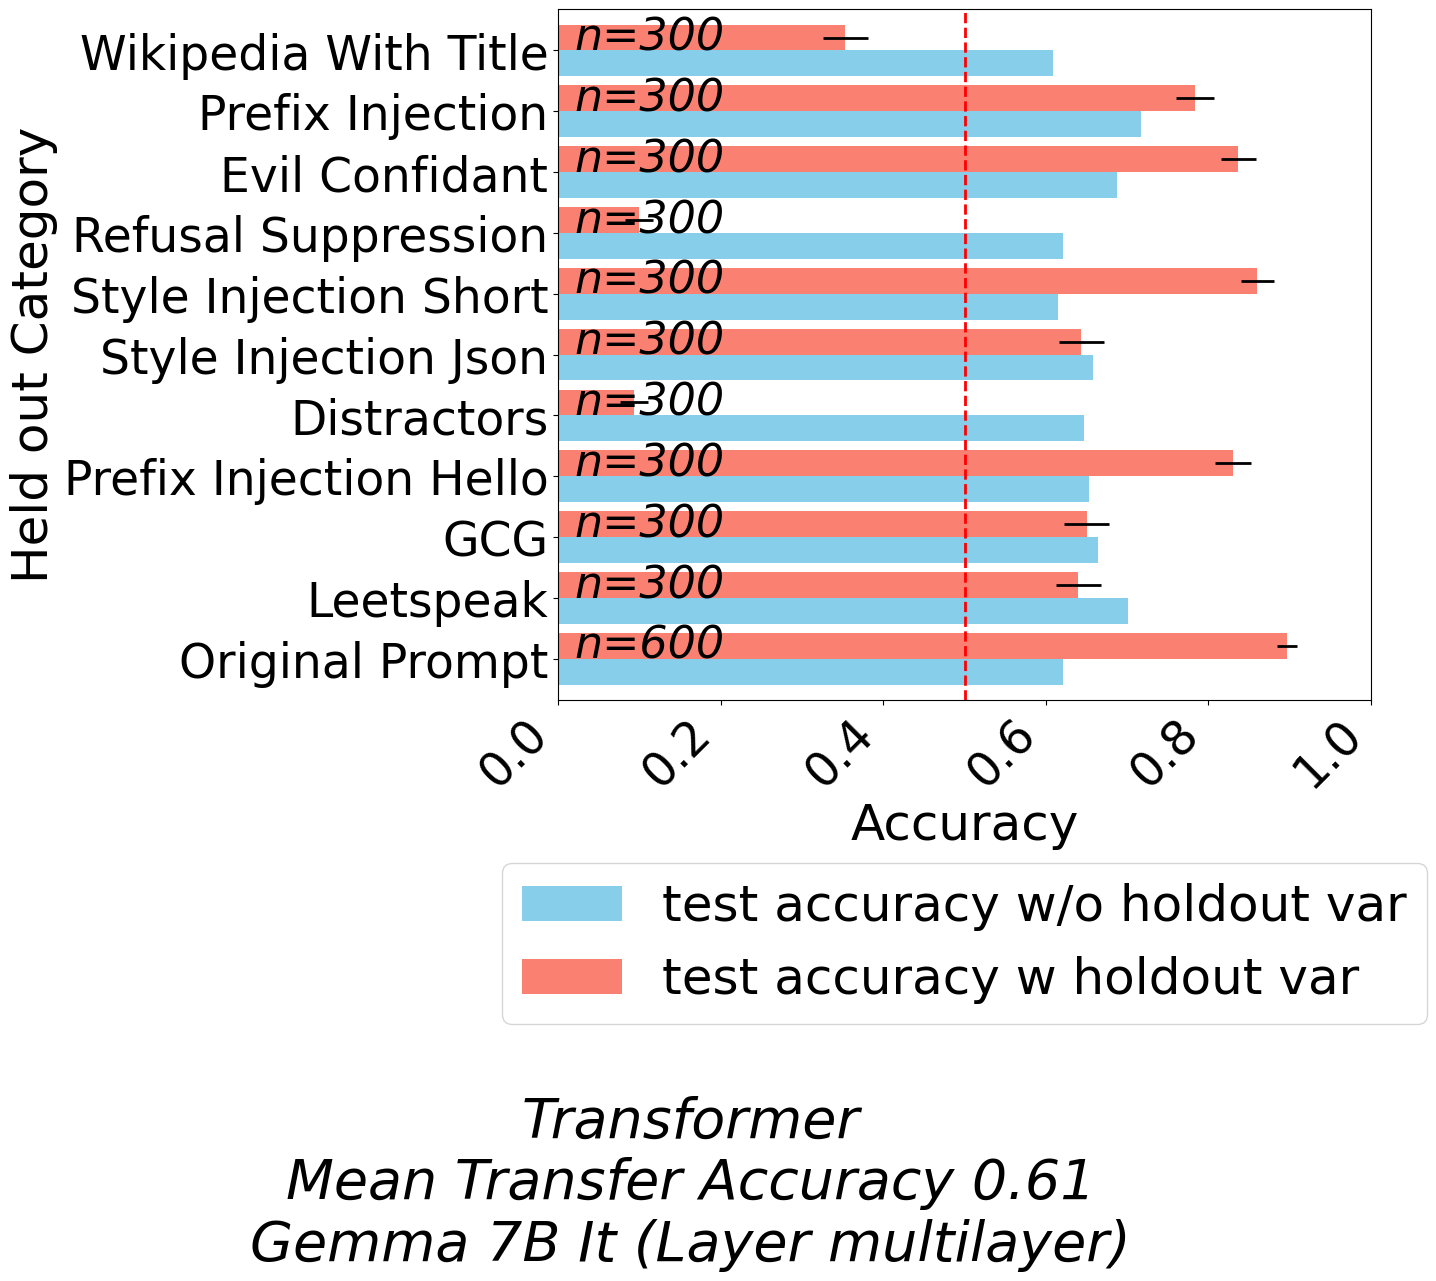

In [28]:
if len(layers) > 1: layer = "multilayer"

plot = holdout_transfer_graph(holdout_df= holdout_df, dataset_name=dataset_name, model_name = model_name, layer = layer, probe_type = "Transformer", mean_tranfer_score= mean_transfer)

In [ ]:
break

# load data 

In [1]:
# Import the init_paths module
from init_paths import (
    PROJECT_ROOT,
    DATASETS_DIR,
    ANALYSIS_DIR,
    EXPERIMENTS_DIR,
    IMAGES_DIR,
    GEN_DATA_DIR,
    LOGS_DIR,
    get_project_path
)

Paths initialized successfully. You can now use PROJECT_ROOT, DATASETS_DIR, etc.


In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 

from analysis.models import * 


publication = ["public_1", "public_2"][1]
models_list = list(models.keys())
model = models_list[3]

probe_types = ["linear", "mlp", "transformer"]

print(model)

Ministral-8B-Instruct


In [8]:
def holdout_transfer_graphs(linear_dfs, mlp_dfs, other_dfs, model_names, savepath=None):
    """
    Create a 3x4 subplot grid of holdout transfer graphs for different models and probe types.

    linear_dfs: List of 4 DataFrames (one per model) for Linear Probes
    mlp_dfs: List of 4 DataFrames (one per model) for MLP Probes
    other_dfs: List of 4 DataFrames (one per model) for Other Probes
    model_names: List of 4 model names (ModelA, ModelB, ModelC, ModelD)
    savepath: Optional path to save the figure
    """
    probe_types = ['Linear Probe', 'MLP Probe', 'Transformer Probe']
    dfs_list = [linear_dfs, mlp_dfs, other_dfs]

    fig, axes = plt.subplots(3, 4, figsize=(26, 18), dpi=300)
    plt.subplots_adjust(wspace=0.3, hspace=0.4)  # Increase padding between graphs

    for row, (probe_type, dfs) in enumerate(zip(probe_types, dfs_list)):
        for col, (holdout_df, model_name) in enumerate(zip(dfs, model_names)):
            ax = axes[row, col]

            holdout_df = holdout_df.reset_index().rename(columns={'index': 'technique'})
            holdout_df.set_index('technique', inplace=True)
            holdout_df.index = [
                str(label).replace('_', ' ').title().replace("Gcg", "GCG").replace("Aim", "AIM")
                for label in holdout_df.index
            ]

            mean_transfer_score = round(holdout_df["test accuracy w holdout var"].mean(), 2)
            test_accuracy = holdout_df['test accuracy w holdout var']
            train_accuracy = holdout_df['test accuracy w/o holdout var']
            test_se = holdout_df['test accuracy SE w holdout var']
            test_size = holdout_df['test size w holdout var']

            holdout_df[['test accuracy w/o holdout var', 'test accuracy w holdout var']].plot(
                kind='barh', ax=ax, color=['skyblue', 'salmon'], linewidth=0.5, width=0.85, legend=False
            )

            y_positions = np.arange(len(test_accuracy)) + ax.patches[0].get_height() / 2
            ax.errorbar(test_accuracy, y_positions, xerr=test_se, fmt='none', ecolor='black', capsize=0, elinewidth=2)

            for y_pos, size in zip(y_positions, test_size):
                ax.text(0.02, y_pos, f'n={size}', va='center', ha='left', fontsize=20, color='black', fontstyle='italic')

            ax.set_xlabel('Accuracy', fontsize=22)
            ax.set_ylabel('Held out Category' if col == 0 else '', fontsize=22)
            ax.set_xticks(np.arange(0, 1.1, 0.1))
            ax.set_xlim(0, 1)
            ax.tick_params(axis='x', rotation=45, labelsize=22)
            ax.tick_params(axis='y', labelsize=22)

            ax.axvline(x=0.50, color='red', linestyle='--', linewidth=2)

            # Only print model names under the bottom row
            if row == 2:
                ax.text(0.5, -0.6, model_name, fontsize=24, ha='center', transform=ax.transAxes, fontweight='bold')
            
            # Display mean accuracy below the figure with more padding
            ax.text(0.5, -0.5, f'Mean: {mean_transfer_score}', fontsize=22, ha='center', transform=ax.transAxes, fontstyle='italic')

    for row, probe_type in enumerate(probe_types):
        fig.text(-0.05, 0.82 - (row * 0.30), probe_type, fontsize=28, fontweight='bold', ha='left', va='center', rotation=90)

    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, ['No Holdout', 'Holdout'], loc='upper center', bbox_to_anchor=(0.5, 0.02), fontsize=20, ncol=2)

    plt.tight_layout(rect=[0.02, 0.07, 0.98, 0.98])  # Adjust overall layout to avoid overlap

    if savepath:
        savepath.parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(savepath, bbox_inches='tight')
    plt.show()


In [10]:
linear_dfs = [pd.read_csv(DATASETS_DIR / f"{publication}/{model_name}/transfer_holdout_linear.csv") for model_name in models_list ]



mlp_dfs = [pd.read_csv(DATASETS_DIR / f"{publication}/{model_name}/transfer_holdout_mlp.csv") for model_name in models_list ]

transformer_dfs = [pd.read_csv(DATASETS_DIR / f"{publication}/{model_name}/transfer_holdout_transformer.csv") for model_name in models_list ]




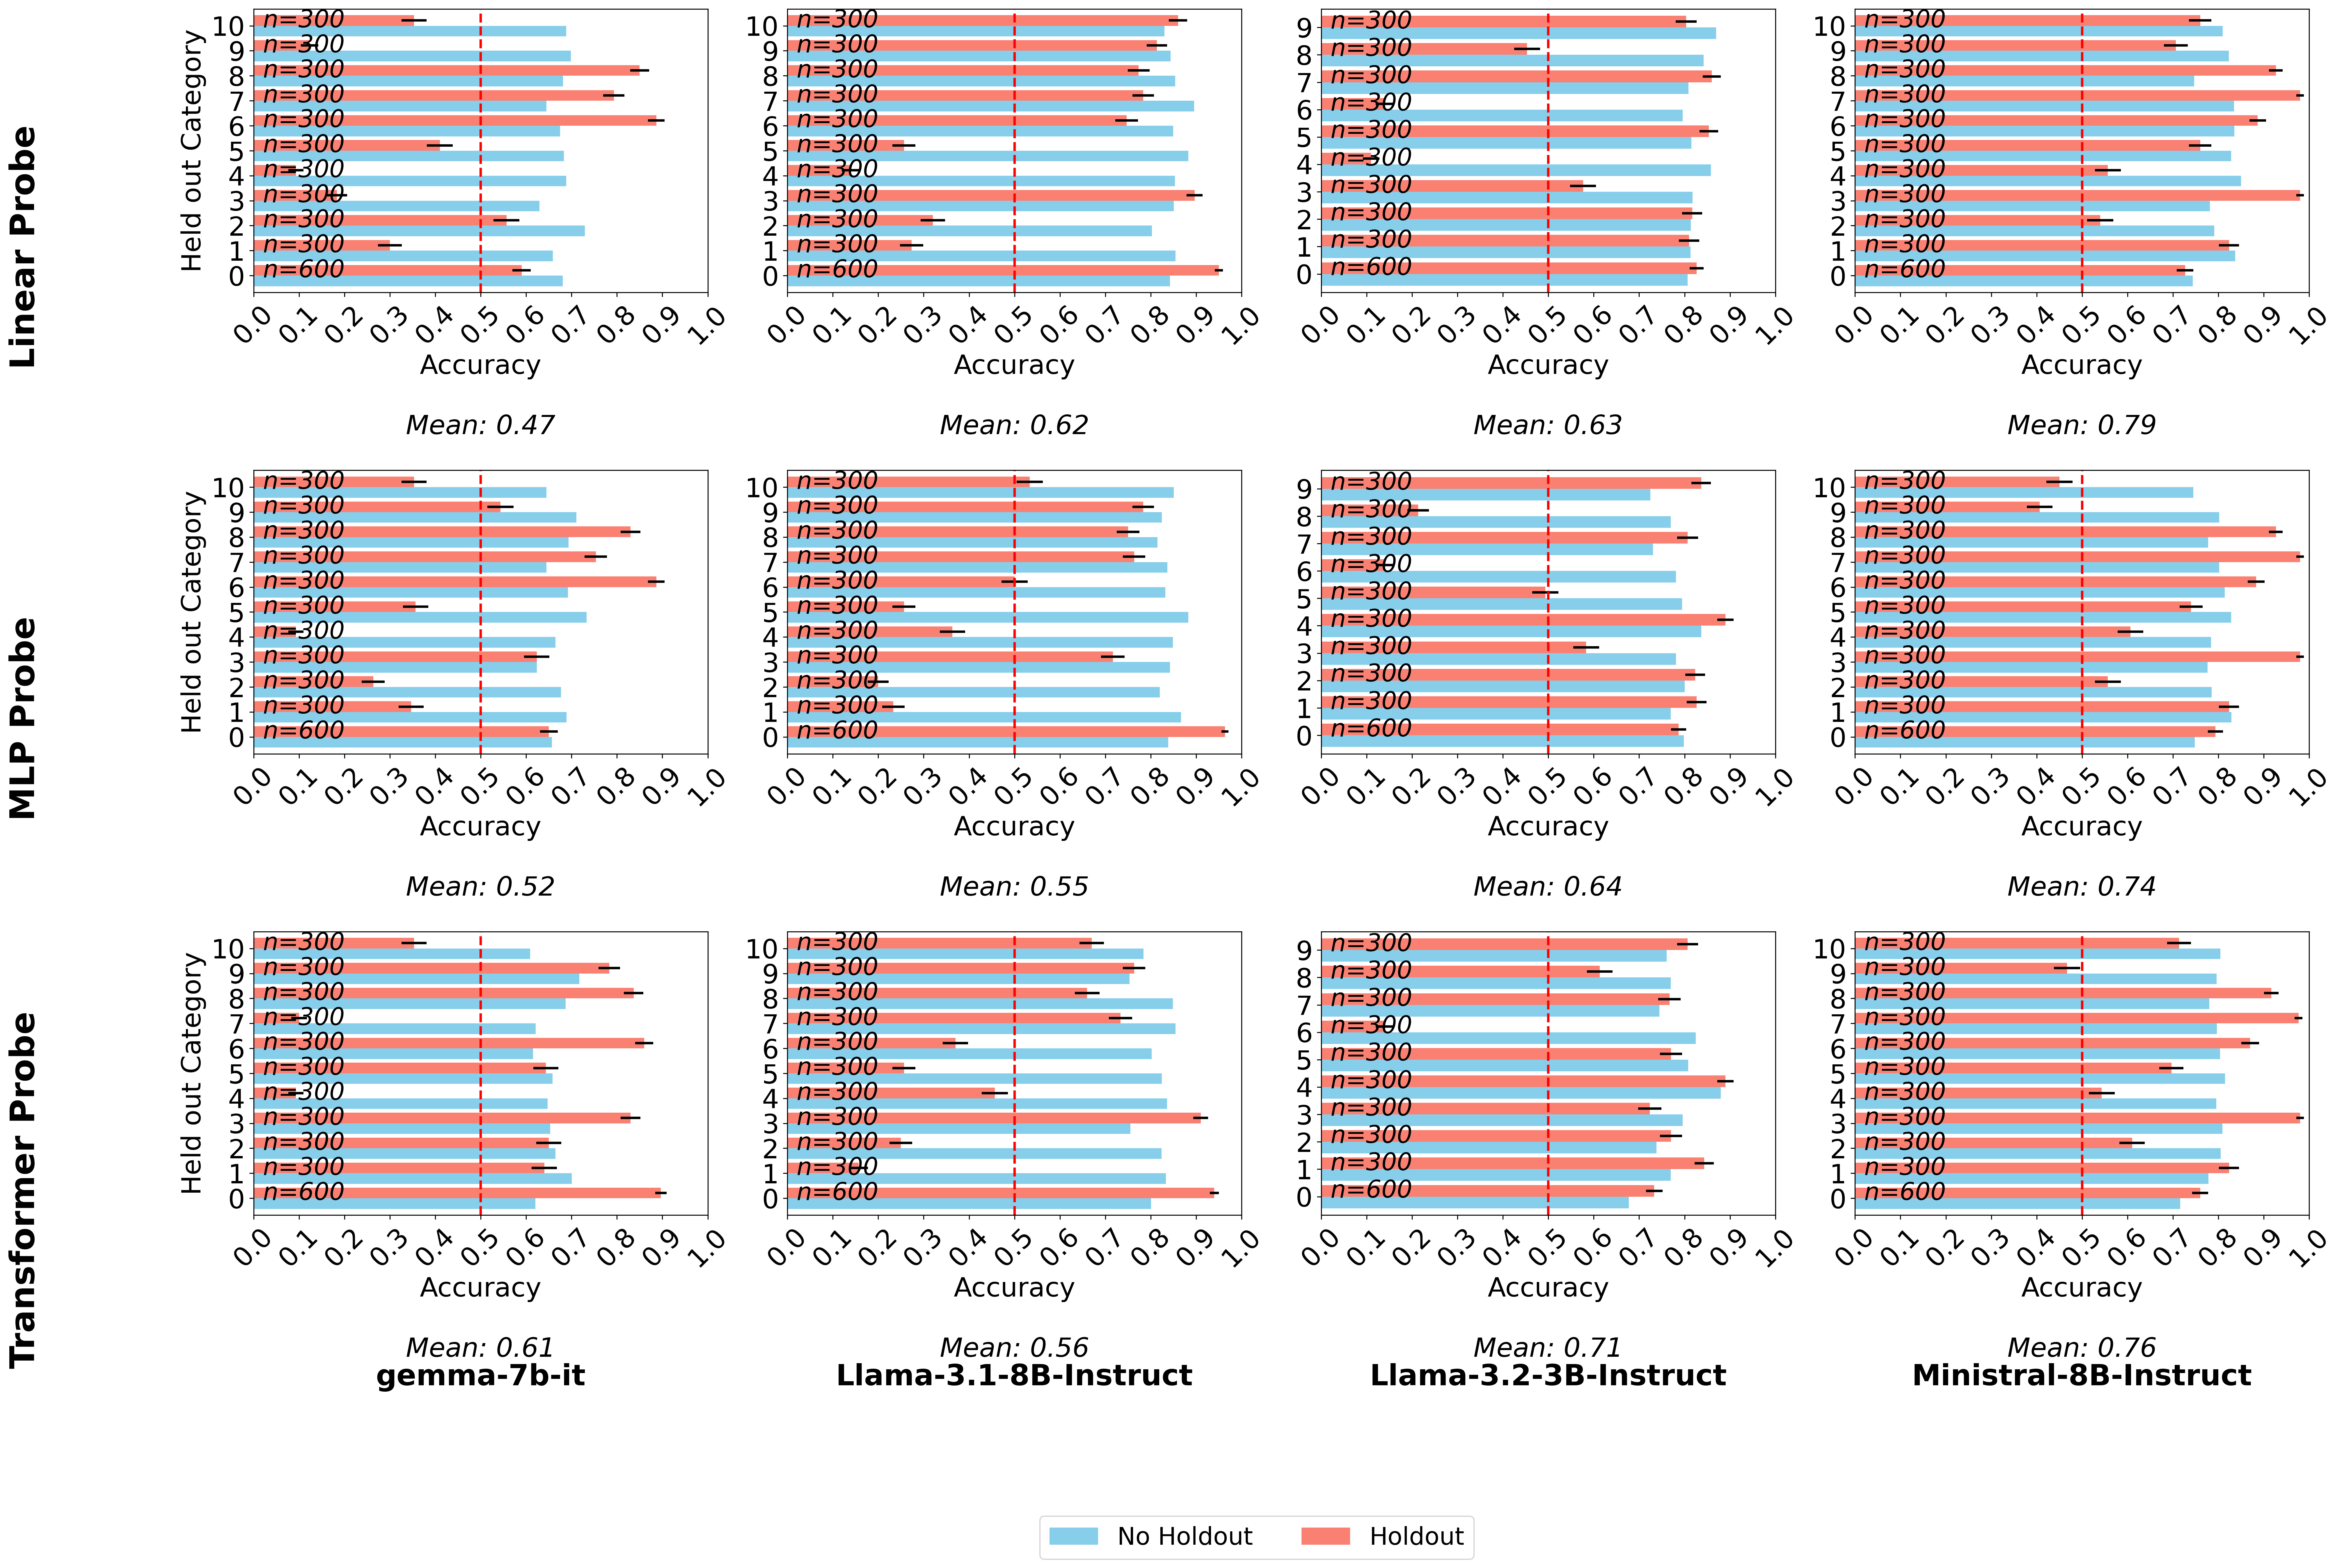

In [11]:
# Assuming you have 4 models and 3 probe types:
from pathlib import Path
# Call the functionf
holdout_transfer_graphs(linear_dfs, mlp_dfs, transformer_dfs, models, savepath= Path(IMAGES_DIR / f"{publication}/transfer/holdout_transfer_graph_all_models.pdf"))


## 